In [0]:
!wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
!tar xvzf gender.tgz

--2020-04-04 14:41:30--  https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zcwlujrtz3izcw8/gender.tgz [following]
--2020-04-04 14:41:30--  https://www.dropbox.com/s/raw/zcwlujrtz3izcw8/gender.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc848153109048693998bece79ad.dl.dropboxusercontent.com/cd/0/inline/A1OvK6gPpCvVHC2DPxH3qAh74OJp6vY7St2QGGBeqtRcQBsmj0OHTVM47PxVqZokYQwZSlf1LAK8seMlvQSNZ1bCbZnjIpMB22iFdKlmE932Bw/file# [following]
--2020-04-04 14:41:30--  https://uc848153109048693998bece79ad.dl.dropboxusercontent.com/cd/0/inline/A1OvK6gPpCvVHC2DPxH3qAh74OJp6vY7St2QGGBeqtRcQBsmj0OHTVM47PxVqZokYQwZSlf1LAK8seMlvQSNZ1bCbZnjIpMB22iFdKlmE932Bw/file
Resolving uc8481531090486

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
%tensorflow_version 1.x
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

TensorFlow 1.x selected.


Using TensorFlow backend.


(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


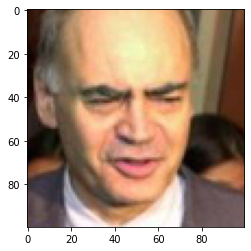

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [0]:
# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))


## View some images
plt.imshow(x_test[ 1700,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)


num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
datagen = ImageDataGenerator(
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.5,
    rotation_range = 10,
    horizontal_flip=True)

# Versión Grande

In [0]:
batch_size = 128
num_classes = 2
epochs = 50
## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
    if (ishape!=0):
        model.add(Conv2D(filters, (3, 3), padding='same',input_shape=ishape))
    else:
        model.add(Conv2D(filters, (3, 3), padding='same'))
        
    model.add(BN())
    model.add(GN(0.1))
    model.add(Activation('relu'))
  
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters, (3, 3), padding='same'))
    model.add(BN())
    model.add(GN(0.1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

  
    return model

## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64,x_train.shape[1:])
model=CBGN(model,128,x_train.shape[1:])

model.add(Flatten())

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()















Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 100, 100, 32)      0         
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 5

In [0]:
## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 50:
        return 0.1
    elif epoch < 75:
        return 0.05
    elif epoch < 100:
        return 0.01
    else:
        return 0.001
    
set_lr = LRS(scheduler)


## TRAINING with DA and LRA
history=model.fit_generator(generator = datagen.flow(x_train,y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)


## TEST
scores = model.evaluate(x_test, y_test, verbose=1) 
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]) 



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
83/82 [==============================] - 29s 346ms/step - loss: 0.7309 - acc: 0.7557 - val_loss: 0.4790 - val_acc: 0.7715
Epoch 2/50
83/82 [==============================] - 25s 303ms/step - loss: 0.4760 - acc: 0.7802 - val_loss: 0.4409 - val_acc: 0.7919
Epoch 3/50
83/82 [==============================] - 25s 304ms/step - loss: 0.4402 - acc: 0.7933 - val_loss: 0.8169 - val_acc: 0.5174
Epoch 4/50
83/82 [==============================] - 25s 305ms/step - loss: 0.4211 - acc: 0.8027 - val_loss: 0.5448 - val_acc: 0.7051
Epoch 5/50
83/82 [==============================] - 25s 306ms/step - loss: 0.4084 - acc: 0.8093 - val_loss: 0.3434 - val_acc: 0.8455
Epoch 6/50
83/82 [==============================] - 25s 306ms/step - loss: 0.3870 - acc: 0.8260 - val_loss: 0.4168 - val_acc: 0.8025
Epoch 7/50
83/82 [==============================] - 25s 306ms/step - loss: 0.3615 - acc: 0.8380 - val_lo

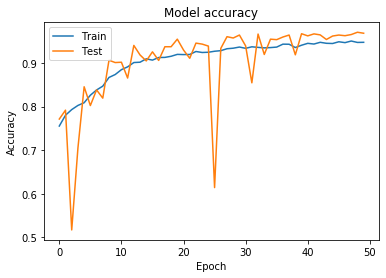

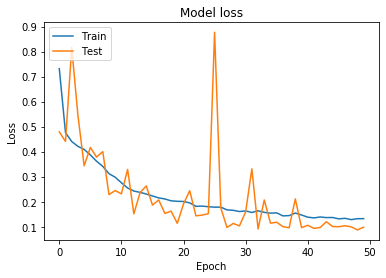

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Evolución del la funcion de perdida en train y test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Versión pequeña


In [0]:
batch_size = 128
num_classes = 2
epochs = 50
## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
    if (ishape!=0):
        model.add(Conv2D(filters, (3, 3), padding='same',input_shape=ishape))
    else:
        model.add(Conv2D(filters, (3, 3), padding='same'))
        
    model.add(BN())
    model.add(GN(0.1))
    model.add(Activation('relu'))
  
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters, (3, 3), padding='same'))
    model.add(BN())
    model.add(GN(0.1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

  
    return model

## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64)
model=CBGN(model,32)

model.add(Flatten())

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
gaussian_noise_7 (GaussianNo (None, 100, 100, 32)      0         
_________________________________________________________________
activation_8 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 50, 50, 32)       

In [0]:
## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 50:
        return 0.1
    elif epoch < 75:
        return 0.05
    elif epoch < 100:
        return 0.01
    else:
        return 0.001
    
set_lr = LRS(scheduler)


## TRAINING with DA and LRA
history=model.fit_generator(generator = datagen.flow(x_train,y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)


## TEST
scores = model.evaluate(x_test, y_test, verbose=1) 
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]) 



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
83/82 [==============================] - 28s 332ms/step - loss: 0.5299 - acc: 0.7640 - val_loss: 0.4759 - val_acc: 0.7761
Epoch 2/50
83/82 [==============================] - 22s 267ms/step - loss: 0.4462 - acc: 0.7929 - val_loss: 0.4267 - val_acc: 0.8104
Epoch 3/50
83/82 [==============================] - 22s 270ms/step - loss: 0.4197 - acc: 0.8034 - val_loss: 0.3957 - val_acc: 0.8312
Epoch 4/50
83/82 [==============================] - 22s 268ms/step - loss: 0.3951 - acc: 0.8213 - val_loss: 0.3504 - val_acc: 0.8421
Epoch 5/50
83/82 [==============================] - 22s 268ms/step - loss: 0.3729 - acc: 0.8311 - val_loss: 0.6364 - val_acc: 0.7836
Epoch 6/50
83/82 [==============================] - 22s 269ms/step - loss: 0.3343 - acc: 0.8547 - val_loss: 0.5907 - val_acc: 0.7885
Epoch 7/50
83/82 [==============================] - 22s 269ms/step - loss: 0.3110 - acc: 0.8668 - val_lo